In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# 딥러닝 장비 세팅
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
# 배치 사이즈, 에포크 설정
BATCH_SIZE = 32
EPOCHS = 10

In [14]:
# Load Datasets
train_dataset = datasets.MNIST(root = "../data/MNIST", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST", train = False, transform = transforms.ToTensor())

# Loader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [15]:
for X_train, y_train in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


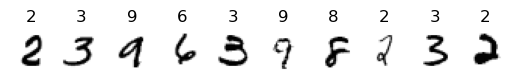

In [21]:
# 데이터셋 모양 출력
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title(y_train[i].item())

In [23]:
# Model 설계
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x: torch.Tensor):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [24]:
# model 불러오기
model = MyNet().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

MyNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [28]:
# 학습함수
def train(model, train_loader, optimizer, log_interval):
    model.train()

    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset)/ BATCH_SIZE)
    test_accuracy = 100. * correct/len(test_loader.dataset)
    return test_loss, test_accuracy

In [29]:
# 학습
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(
        epoch, test_loss, test_accuracy))

Train epoch: 1 [0/60000 (0%)]	Train Loss: 2.351913
Train epoch: 1 [6400/60000 (11%)]	Train Loss: 2.262727
Train epoch: 1 [12800/60000 (21%)]	Train Loss: 2.318629
Train epoch: 1 [19200/60000 (32%)]	Train Loss: 2.280891
Train epoch: 1 [25600/60000 (43%)]	Train Loss: 2.275347
Train epoch: 1 [32000/60000 (53%)]	Train Loss: 2.311821
Train epoch: 1 [38400/60000 (64%)]	Train Loss: 2.292436
Train epoch: 1 [44800/60000 (75%)]	Train Loss: 2.255321
Train epoch: 1 [51200/60000 (85%)]	Train Loss: 2.272655
Train epoch: 1 [57600/60000 (96%)]	Train Loss: 2.249749

[EPOCH: 1], 	Test Loss: 2.2264, 	Test Accuracy: 16.37 %

Train epoch: 2 [0/60000 (0%)]	Train Loss: 2.248021
Train epoch: 2 [6400/60000 (11%)]	Train Loss: 2.191634
Train epoch: 2 [12800/60000 (21%)]	Train Loss: 2.142312
Train epoch: 2 [19200/60000 (32%)]	Train Loss: 2.118611
Train epoch: 2 [25600/60000 (43%)]	Train Loss: 1.983408
Train epoch: 2 [32000/60000 (53%)]	Train Loss: 1.752541
Train epoch: 2 [38400/60000 (64%)]	Train Loss: 1.621728
Tr